# Project 3: Federated Semantic Segmentation for self-driving cars

## Imports

First are installed a couple of extra packets for visualization of data and progress

In [ ]:
!pip install cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=cd6763aa06377fa9c85d18b21383ffcdf62b6734b86e0ab1b07bf0a16ab60685
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


The drive is mounted then.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
cd /content/drive/MyDrive/Projeto-DAAI 

/content/drive/.shortcut-targets-by-id/1axrTLXe8kO9kBLCogPxZ0cgQWKU7efJZ/Projeto-DAAI


In [ ]:
cd /content/drive/MyDrive/DAAI/Project # orsi 

[Errno 2] No such file or directory: '/content/drive/MyDrive/DAAI/Project # orsi'
/content/drive/.shortcut-targets-by-id/1axrTLXe8kO9kBLCogPxZ0cgQWKU7efJZ/Projeto-DAAI


The libraries are imported, with the specific functions mainly from pyTorch, as demanded in the Project PDF.
The created functions are also imported.

In [ ]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import numpy as np
from PIL import Image 
from matplotlib import cm 



import transforms
import data_mng as data
import networks
from cityscapes import Cityscapes
from client import Client
from server import Server
from GTA5 import GTA5
import FDA_source_to_target as FDA
from student import Student

import torch.optim as optim
from torch.utils.data import Subset, DataLoader

import mIoU
import wandb
import random
import time
import os
import json

The wanb is the plataform that is used to vizualize the resultls more easily. Here is the login to it using the API key: 

In [ ]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

## Configuration
Here the configuration of the network is done. The path of the dataset files are defined, as well as the hyparameters used, the transforms, the dataset partitions from step 1 are created, the dataloaders are loaded into variables. The 'cuda' device is also specified here.

The dataset classes are created in separated `.py` filies, also the auxiliary functions to help with the partitions and splits are in the }`data_mng,py` file, previously imported.

The length of the datasets are checked, as well as the device being currently used.

In [ ]:
### PARTITIONING CITYSCAPES INTO TRAIN AND TEST

# creating variables for the files directories
CS_data_dir = './data/Cityscapes/images'
CS_labels_dir = './data/Cityscapes/labels'
CS_txt_train_file = './data/Cityscapes/train.txt'
CS_txt_test_file = './data/Cityscapes/val.txt'


GTA5_data_dir = './data/GTA5/images'
GTA5_labels_dir = './data/GTA5/labels'
GTA5_annotation = './data/GTA5/train.txt'
GTA5_data_dir_FDA_AI = './data/GTA5/images_FDA_split_A_I'
GTA5_data_dir_FDA_AII = './data/GTA5/images_FDA_split_A_II'
GTA5_data_dir_FDA_BI = './data/GTA5/images_FDA_split_B_I'
GTA5_data_dir_FDA_BII = './data/GTA5/images_FDA_split_B_II'

# general parameters - adapted from paper [2] of the project pdf
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

# resizing parameters
height, width = 512, 1024

batch_size = 4
LR = 0.1             # The initial Learning Rate
momentum = 0.9       #
weight_decay = 5e-4  # Regularization, default value is ok
epochs = 30          # Total number of training epochs (iterations over dataset)
step_size = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
gamma = 0.1          # Multiplicative factor for learning rate step-down
number_classes = 19  # number of classes for the cityscapes dataset

hyperparam = {"LR": LR,
         "MOMENTUM": momentum,
         "WEIGHT_DECAY": weight_decay,
         "STEP_SIZE": step_size,
         "GAMMA": gamma
         }

##------------FedAvg+SS------------
batch_size_fedavg = 2
LR_fedavg = 0.1
momentum_fedavg = 0.9
weight_decay_fedavg = 5e-4

epochs_fedavg = 4
step_size_fedavg = 2
gamma_fedavg  = 0.1
number_rounds = 25
number_clients = 50

hyperparam_fedavg = {"LR": LR_fedavg,
         "MOMENTUM": momentum_fedavg,
         "WEIGHT_DECAY": weight_decay_fedavg,
         "STEP_SIZE": step_size_fedavg,
         "GAMMA": gamma_fedavg
         }

wandb_config_fedavg = {
        "initial_lr": LR_fedavg,
        "step_size": step_size_fedavg,
        "gamma": gamma_fedavg,
        "batch_size": batch_size_fedavg,
        "rounds": number_rounds,
        "dataset": "dataset_A",
        "split": 'split_A_I'
        }






#wandb config 
config = {"learning_rate": LR,
          "batch_size": batch_size,
          "momentum": momentum,
          "weight_decay": weight_decay,
          "epochs": epochs,
          "step_size": step_size,
          "gamma": gamma,
          "number_classes": number_classes    
}






# transforms - adapted from paper [2]
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), 
transforms.RandomCrop((height,width)),
transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

test_transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])


# creating test and train partitions for datasets A and B
train_A, test_A = data._dataset_info_A(CS_data_dir,train=True), data._dataset_info_A(CS_data_dir,train=False)
train_B, test_B = data._dataset_info_B(CS_txt_train_file), data._dataset_info_B(CS_txt_test_file)

# loading datasets and dataloaders for partition A
training_data_A = Cityscapes(CS_data_dir,CS_labels_dir, train_A, transform=train_transform, cl19 = True)
testing_data_A = Cityscapes(CS_data_dir,CS_labels_dir, test_A, transform=test_transform, cl19 = True)
train_dataloader_A = DataLoader(training_data_A, batch_size=batch_size, shuffle=True)
test_dataloader_A = DataLoader(testing_data_A, batch_size=batch_size, shuffle=False)

# checking the size of the datasets for the A partition
print(f'Train Dataset A: {len(training_data_A)}')
print(f'Test Dataset A: {len(testing_data_A)}')

# loading datasets for partition B
training_data_B = Cityscapes(CS_data_dir,CS_labels_dir, train_B, transform=train_transform, cl19 = True)
validation_data_B = Cityscapes(CS_data_dir,CS_labels_dir, test_B, transform=test_transform, cl19 = True)
train_dataloader_B = DataLoader(training_data_B, batch_size=batch_size, shuffle=True)
val_dataloader_B = DataLoader(validation_data_B, batch_size=batch_size, shuffle=False)

# checking the size of the datasets for the B partition
print(f'Train Dataset B: {len(training_data_B)}')
print(f'Test Dataset B: {len(validation_data_B)}')

# loading GTA5 dataset with no transform and dataloader into variable
GTA5_ds = GTA5(GTA5_data_dir,GTA5_labels_dir,GTA5_annotation,transform = train_transform, cl19=True)
GTA5_dl = DataLoader(GTA5_ds, batch_size=batch_size, shuffle=True) 

# checking the size of the datasets for GTA dataset
print(f'Dataset GTA: {len(GTA5_ds)}')

# creating uniform (I) and heterogeneous (II) for A and B train partitions
split_A_II = data.heterogeneous_split(training_data_A, number_clients)
split_B_II = data.heterogeneous_split(training_data_B, number_clients)
split_A_I = data.uniform_split(training_data_A, number_clients)
split_B_I = data.uniform_split(training_data_B, number_clients)

Using cuda device
Train Dataset A: 708
Test Dataset A: 42
Train Dataset B: 500
Test Dataset B: 250
Dataset GTA: 500


## STEP 1: PARTITION CITYSCAPES INTO TRAIN AND TEST
The datasets are created with the specified partitions in the previous code cell. The following code is for visualization of the dataset images and labels, to check if the label files are corresponding to the correct image, and if the dataset class is properly implemented.

torch.Size([1024, 2048, 3]) 
 torch.Size([1024, 2048])


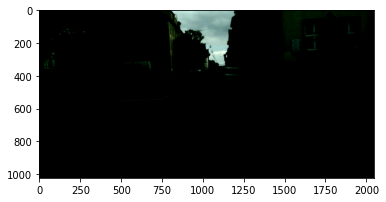

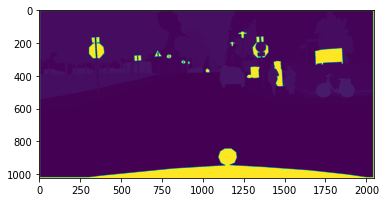

In [ ]:

# checking if the dataset implementation is correct: plotting images and labels
img, label = testing_data_A[15] # loading first image and label from the train partition A
print(img.permute(1,2,0).shape,'\n',label.shape)
plt.imshow(img.permute(1,2,0),vmin=0, vmax=1) # the permute function is to change the order of the 
# dimensions of the tensor so that it is compatible with the expected format in matplotlib
plt.show()
plt.imshow(label)
plt.show()



## STEP 2:  CENTRALIZED BASELINE
The train and test of the network is made in this step. The Cityscapes dataset is used with the A and B specified and previously developed partitions.

The network is in the `networks.py` file.

First the cache of the GPU is emptied, the network itself is loaded to the varibale `net` and brought into the GPU.

In [ ]:
torch.cuda.empty_cache()
net = networks.BiSeNetV2(n_classes=number_classes) # loading the BiSeNet network
net = net.to(device) # bringing the network to GPU if device is 'cuda'

The partition A of the Cityscapes dataset is trained in the following code cell, with the `Client` class being defined in the `client.py` file.

In [ ]:
#train network with dataset A
#define saving path
client = "centralized-datasetA-100epochs"   #define client
path = "./saved"
save_path = os.path.join(path, "{}.pth".format(client))

if os.path.exists(save_path):
  print("Client already trained..\nChange the name of the client")
else:
  print("New client: ", client)

wandb.init(project="DAAI - datasetA", config = config)
client_dsA = Client(f"{wandb.run.name}-datasetA",training_data_A, net, batch_size, device, epochs, hyperparam, number_classes)
client_dsA.train(epochs, hyperparam, save_path) #(epochs, hyperparam, save_path)
wandb.finish()


Same procedure for the dataset B.

In [ ]:
# training using dataset B
torch.cuda.empty_cache()
net = networks.BiSeNetV2(n_classes=number_classes) # loading the BiSeNet network
net = net.to(device) # bringing the network to GPU if device is 'cuda'

client = "centralized-datasetB"   #define client
path = "./saved"
save_path = os.path.join(path, "{}.pth".format(client))

if os.path.exists(save_path):
  print("Client already trained..\nChange the name of the client")
else:
  print("New client: ", client)

wandb.init(project="DAAI - datasetB", config = config)
client_dsB = Client(f"{wandb.run.name}-datasetB",training_data_B, net, batch_size, device, epochs, hyperparam, number_classes)
client_dsB.train(epochs, hyperparam, save_path) #(epochs, hyperparam, save_path)
wandb.finish()

After trained, the network is saved in the path defined. The following cell is for the testing with both datasets A and B

Loaded model: saved/centralized-datasetA.pth.


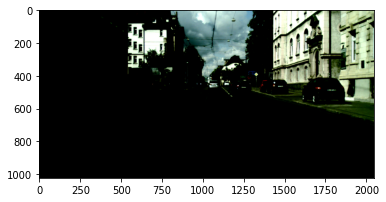

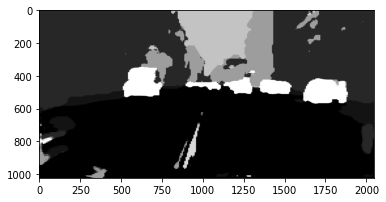

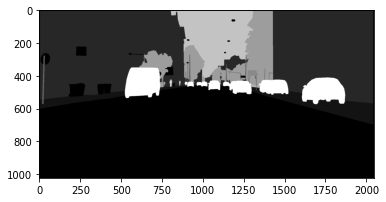

Accuracy: 0.3872594810284117


In [ ]:
# testing the dataset A partition for the baseline
load_path = "saved/centralized-datasetA.pth" #"saved/centralized-datasetB.pth"

torch.cuda.empty_cache()
test_net = networks.BiSeNetV2(number_classes)
test_net.to(device)

test_client = Client(f"test_client",testing_data_A, test_net, batch_size, device, epochs, hyperparam, number_classes)
test_client.load_model(load_path)

mIoU_accuracy = test_client.test()
print(f"Accuracy: {mIoU_accuracy}")

## STEP 3: FEDERATED SEMANTIC SEGMENTATION EXPERIMENTS
Now the clients are defined and its datasets created. The same `Client` class used in step 2 is used here to test the network.

Here, also a server is used, which is defined in the `server.py` file. It is responsable for testing the clients from a client list, and update the network with an average of the wrights of each client.

The uniform and heterogeneous splits are made using the auxiliary functions presnt in `data_mng` file.

The different clients are trained in a loop, the results are sent to the server, which makes an averaging of the results of the client list and saves the new averaged result.

The uniform split A is being used here, the same can be done with the heterogeneous split and with the B partition, based on the boolean variable in the configuration section.

In [ ]:
save_server_path = "./saved/3_server_A_II_uni.pth"

torch.cuda.empty_cache()
net_fedavg = networks.BiSeNetV2(number_classes)
net_fedavg.to(device)

clients = []
for cl in range(len(split_A_II)):
  client_dataset = Cityscapes(CS_data_dir,CS_labels_dir, split_A_II[cl], transform=train_transform, cl19 = True)
  client = Client(f"c{cl}", client_dataset, net_fedavg, batch_size_fedavg, device, epochs_fedavg, hyperparam_fedavg, autosave=False)
  clients.append(client)

wandb_config_fedavg['split'] = 'split A II (het)' # 'split A II (het)' , 'split A I (uni)'
wandb.init(project = "FedAvgSS", config = wandb_config_fedavg)
server = Server(f"{wandb.run.name}_serverA", net_fedavg, device, clients, hyperparam=hyperparam_fedavg, number_classes=number_classes, epochs_per_client=epochs_fedavg)
server.training_fedAvg(clients, rounds=number_rounds, path_server_model=save_server_path)
wandb.finish()


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


AssertionError: ignored

Same procedure is done, but using the dataset B.

In [ ]:
# training using clients
save_server_path = "./saved/3_server_B_II_het.pth"

torch.cuda.empty_cache()
net_fedavg = networks.BiSeNetV2(number_classes)
net_fedavg.to(device)


clients = []
for cl in range(len(split_B_II)):
  client_dataset = Cityscapes(CS_data_dir,CS_labels_dir, split_B_II[cl], transform=train_transform, cl19 = True)
  client = Client(f"c{cl}", client_dataset, net_fedavg, batch_size_fedavg, device, epochs_fedavg, hyperparam_fedavg, autosave=False)
  clients.append(client)

wandb_config_fedavg["dataset"] = "dataset B"
wandb_config_fedavg['split'] = 'split B II (het)' # 'split B II (het)', 'split B I (uni)'
wandb.init(project = "FedAvgSS", config = wandb_config_fedavg)
server = Server(f"{wandb.run.name}_serverB", net_fedavg, device, clients, hyperparam=hyperparam_fedavg, number_classes=number_classes, epochs_per_client=epochs_fedavg)
server.training_fedAvg(clients, rounds=number_rounds, path_server_model=save_server_path)
wandb.finish()

After trained with the different clients, the network is tested using the test partitions of A or B datasets.

Loaded model: saved/3_server_B_II_het.pth.


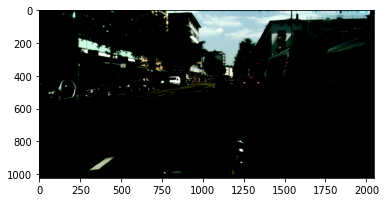

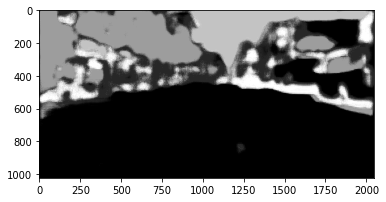

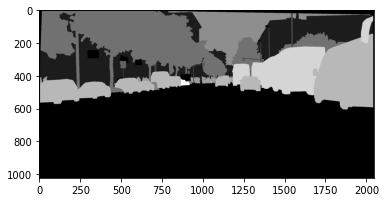

Accuracy: 0.14109894779437582


In [ ]:
# test client with server model
load_path = "saved/3_server_B_II_het.pth"

torch.cuda.empty_cache()
test_server_net = networks.BiSeNetV2(number_classes)
test_server_net.to(device)

test_server = Client(f"test_server",validation_data_A, test_server_net, batch_size, device, epochs, hyperparam, number_classes, server = True)
test_server.load_model(load_path)

mIoU_accuracy = test_server.test()
print(f"Accuracy: {mIoU_accuracy}")

### STEP 4: MOVING TOWARDS FFreeDA - PRE-TRAINING PHASE
Primarily the GTA5 dataset class is created, the directories are defined, also the dataset and dataloader are loaded into variable, like it was done with the Cityscapes A and B partitions.

Train GTA5 dataset: 500


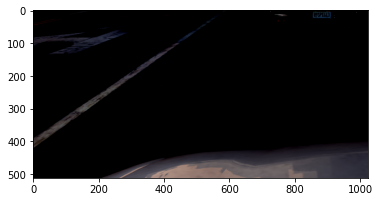

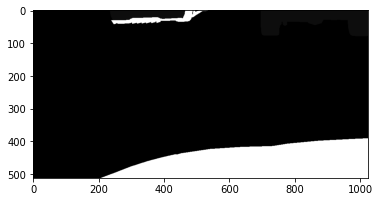

In [ ]:
### STEP 4 - using GTA 5 dataset.

# loading GTA5 dataset with no transform and dataloader into variable
GTA5_ds = GTA5(GTA5_data_dir,GTA5_labels_dir,GTA5_annotation,transform = train_transform, cl19=True)
GTA5_dl = DataLoader(GTA5_ds, batch_size=batch_size, shuffle=True) 

# checking the size of the GTA5 dataset
print(f'Train GTA5 dataset: {len(GTA5_ds)}')

# checking if the dataset implementation is correct: plotting images and labels
img, label = GTA5_ds[10] # loading random image and label from the dataset
plt.imshow(img.permute(1,2,0), cmap='gray') # the permute function is to change the order of the 
# dimensions of the tensor so that it is compatible with the expected format in matplotlib
plt.show()
plt.imshow(label, cmap='gray')
plt.show()

The netwrok is trained from scratch, but using the GTA5 dataset as source. This is done for the Domain Adaptation task.

In [ ]:
#training with GTA dataset
save_path = "./saved/client_GTA5.pth"

torch.cuda.empty_cache()
GTA_net = networks.BiSeNetV2(number_classes)
GTA_net.to(device)


config["FDA"] = False
wandb.init(project = "GTA", config = config)

client_GTA = Client(f"{wandb.run.name}-client_GTA", GTA5_ds, GTA_net, batch_size, device, epochs, hyperparam, number_classes)
client_GTA.train(epochs, hyperparam, save_path)
wandb.finish()

Here the GTA model is tested with Cityscapes dataset both A and B test partitions

Loaded model: saved/client_GTA5.pth.


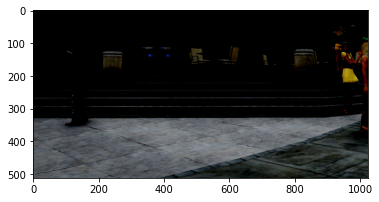

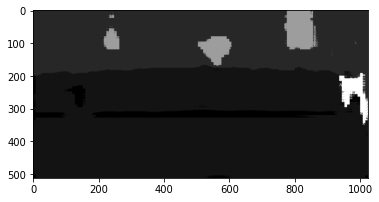

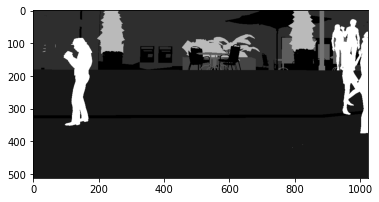

Accuracy: 0.21015242269100287


In [ ]:
#test with Cityscape dataset
#
load_path = "saved/client_GTA5.pth"

torch.cuda.empty_cache()
test_GTA5_net = networks.BiSeNetV2(number_classes)
test_GTA5_net.to(device)

test_GTA5 = Client(f"test_GTA5",GTA5_ds, test_GTA5_net, batch_size, device, epochs, hyperparam, number_classes, server=True)
test_GTA5.load_model(load_path)

mIoU_accuracy = test_GTA5.test()
print(f"Accuracy: {mIoU_accuracy}")

### Domain Adaptation

Here it is created the bank of styles for a list of clients and then it is created a new directory by randomly applying the styles on the images coming from GTA 5 dataset.
Each run will create one new GTA5 dataset modified by the different styles depending on the split selected.

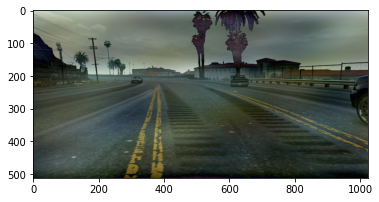

In [ ]:
#------------------NO NEED TO RUN THIS PART AGAIN ----------------------------#

#list of clients - we apply the transform only after the  
#                domain adaptation between source and target

# To use FDA_source_to_target_np function apply the following code to the image from tuple (image, label)
#    src_img = np.array(src_img)
#    im = Image.fromarray(np.uint8(src_img))
#    im_src1 = im.resize( (1024,512), Image.BICUBIC )
#    im_src2 = np.asarray(im_src1, np.float32)
#    im_src3 = im_src2.transpose((2, 0, 1))
torch.cuda.empty_cache()
net_fedavg = networks.BiSeNetV2(number_classes)
net_fedavg.to(device)

#list of clients
clients = []
for i, cl in enumerate(split_A_I):   #split_A_II    #split_B_I    #split_B_II
  client_dataset = Cityscapes(CS_data_dir,CS_labels_dir, split_A_I[i], transform=None, cl19 = True)  #create dataset for client i
  client = Client(f"c{cl}", client_dataset, net_fedavg, batch_size_fedavg, device, epochs_fedavg, hyperparam_fedavg, autosave=False)  #create the object Client for each client on the list with its own dataset
  clients.append(client)


#create bank of styles
bank_of_styles = []
sum_amp = 0
number_img = 0
for client in clients:
  for img, label in client.dataset:
    src_img = img
    #get amplitude of frequencies cropped to the center
    amp_src = FDA.get_amplitude(src_img, L=0.01) #input - image from tuple (image, label), L = square to crop center of amplitude signal
    sum_amp += amp_src
    number_img += 1
  avg_amp = sum_amp/number_img
  bank_of_styles.append(avg_amp)

directory = "./data/GTA5/images_FDA"    #"./data/GTA5/images_FDA_split_A_I"
GTA5_FDA = []
GTA5_dataset = GTA5(GTA5_data_dir,GTA5_labels_dir,GTA5_annotation,transform=None, cl19=True)

# New GTA5 dataset with domain adaptation - save new imagens in a folder
for i in range(len(GTA5_dataset)):
  img, label = GTA5_dataset[i]

  img = FDA.apply_style(img, bank_of_styles, L=0.01)
  img = np.abs(img.transpose((1,2,0)))
  im = Image.fromarray(np.uint8(img))

  path = os.path.join(directory, GTA5_dataset.images[i])

  im.save(path,"png")

plt.imshow(img.astype('uint8'))
#GTA5_dsda = GTA5(GTA5_data_dir,GTA5_labels_dir,GTA5_annotation,transform=train_transform, cl19=True)
#GTA5_dataset = GTA5(GTA5_data_dir,GTA5_labels_dir,GTA5_annotation,transform=None, cl19=True)

#torch.cuda.empty_cache()
#GTA5_net = networks.BiSeNetV2(number_classes)
#GTA5_net.to(device)

Now we train the network with every new dataset created

In [ ]:
#training with new GTA dataset with domain adaptation
save_path = "./saved/client_GTA5_FDA_split_B_II.pth"
data_dir = GTA5_data_dir_FDA_BII

torch.cuda.empty_cache()
GTA_net = networks.BiSeNetV2(number_classes)
GTA_net.to(device)
GTA5_ds_FDA = GTA5(data_dir,GTA5_labels_dir,GTA5_annotation,transform=train_transform, cl19=True)

config["FDA"] = True
wandb.init(project = "GTA", config = config)

client_GTA = Client(f"{wandb.run.name}-client_GTA", GTA5_ds_FDA, GTA_net, batch_size, device, epochs, hyperparam, number_classes)
client_GTA.train(epochs, hyperparam, save_path)
wandb.finish()

Here all the four models are tested with test set A and B (both uniform and heterogeneous split)

Loaded model: saved/client_GTA5_FDA_split_B_II.pth.


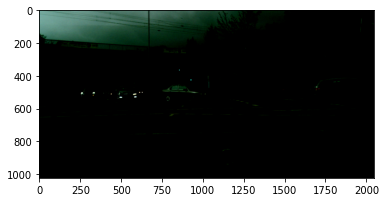

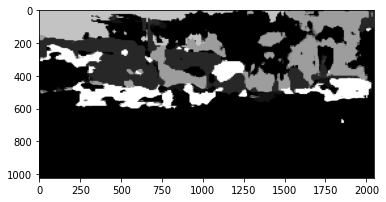

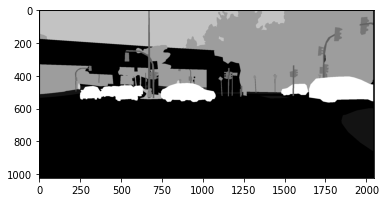

Accuracy: 0.17497256671260433


In [ ]:
#test with Cityscape dataset
# 
load_path = "saved/client_GTA5_FDA_split_B_II.pth"  #"saved/client_GTA5_FDA_split_A_II.pth  #"saved/client_GTA5_FDA_split_A_I.pth"  #"saved/client_GTA5_FDA_split_B_I.pth"

torch.cuda.empty_cache()
test_GTA5_net = networks.BiSeNetV2(number_classes)
test_GTA5_net.to(device)

test_GTA5 = Client(f"test_GTA5",validation_data_B, test_GTA5_net, batch_size, device, epochs, hyperparam, number_classes, server=True)
test_GTA5.load_model(load_path)

mIoU_accuracy = test_GTA5.test()
print(f"Accuracy: {mIoU_accuracy}")

## STEP 5: FEDERATED SELF-TRAINING USING PSEUDO-LABELS
The training with the cityscapes dataset is made. For each partition (A, B) and split (I, II), the corresponding best checkpoint from step 4.2 (GTA5 dataset set for training) is loaded and a FedAvg training on Cityscapes is performed using
pseudo-labels as ground-truth labels for the model, without using the original
labels for training.

The same splits and partitions previously developed are used in this section.

Split I is uniform, split II is heterogeneous.



```
# This is formatted as code
```

The 'T' variable defines how often the teacher model is updated in the `Server` class:

    i) T = 0: teacher model never updated
    ii) T = 1: teacher model = server model at the beginning of each round
    iii) teacher model = server model every T>1 rounds

In the following code cell, the 3 different values of T are tested on the split I of dataset partition B.


In [ ]:
# creaing varibale to save server
ST_save_server_path = "./saved/ST_server_B_I.pth"

T_list = [0, 1, 3]

# training using best saved checkpoint from 4.2 or 4.4
load_path = "saved/client_GTA5.pth" # input the saved model from 4.2 or 4.4

# best T is T = 1
for i in range(len(T_list)): 
    # defining T
    T = T_list[i]

    # creatin the teacher and student models
    torch.cuda.empty_cache()
    teacher_model = networks.BiSeNetV2(number_classes).to(device)
    student_model = networks.BiSeNetV2(number_classes).to(device)

    # creating clients list for the self-training task
    clients = []
    for cl in range(len(split_B_I)):
      client_dataset = Cityscapes(CS_data_dir,CS_labels_dir, split_B_I[cl], transform=train_transform, cl19 = True)
      client = Student(f'client_ST{cl}',client_dataset, student_model,batch_size_fedavg, device, epochs_fedavg, hyperparam_fedavg, number_classes,teacher=teacher_model,autosave=False)

      # loading the pre-trained models from 4.2 (best checkpoint)
      client.load_teacher(load_path)
      client.load_model(load_path)

      clients.append(client)

    wandb_config_fedavg["dataset"] = f"ST split B I t={i}"
    wandb.init(project = "Self-Training-FedAvg", config = wandb_config_fedavg)
    ST_server = Server(f"{wandb.run.name}_serverBI", teacher_model, device, clients, hyperparam=hyperparam_fedavg, number_classes=number_classes, epochs_per_client=epochs_fedavg, isstudent=True)
    ST_server.load_model(load_path)
    ST_server.training_fedAvg(clients, rounds=number_rounds, t=T, path_server_model=ST_save_server_path)
    wandb.finish()

The best T value validated through the training on the previous code section is T = 1. In the following cell all the other splits are trained with the best T value.

In [ ]:
split = 'II' # 'I' for uniform and 'II' for het
part = 'A'

# creaing varibale to save server
ST_save_server_path = f"./saved/ST_server_{part}_{split}.pth"

# training using best saved checkpoint from 4.2 or 4.4
load_path = "saved/client_GTA5.pth" # input the saved model from 4.2 or 4.4

# best T is T = 1
# defining T
T = 1

# creatin the teacher and student models
torch.cuda.empty_cache()
teacher_model = networks.BiSeNetV2(number_classes).to(device)
student_model = networks.BiSeNetV2(number_classes).to(device)

# creating clients list for the self-training task
clients = []
for cl in range(len(split_A_II)):
  client_dataset = Cityscapes(CS_data_dir,CS_labels_dir, split_A_II[cl], transform=train_transform, cl19 = True)
  client = Student(f'client_ST{cl}',client_dataset, student_model,batch_size_fedavg, device, epochs_fedavg, hyperparam_fedavg, number_classes,teacher=teacher_model,autosave=False)

  # loading the pre-trained models from 4.2 (best checkpoint)
  client.load_teacher(load_path)
  client.load_model(load_path)

  clients.append(client)

wandb_config_fedavg["dataset"] = f"ST split {part} {split} t=1"
wandb.init(project = "Self-Training-FedAvg", config = wandb_config_fedavg)
ST_server = Server(f"{wandb.run.name}_server{part}{split}", teacher_model, device, clients, hyperparam=hyperparam_fedavg, number_classes=number_classes, epochs_per_client=epochs_fedavg, isstudent=True)
ST_server.load_model(load_path)
ST_server.training_fedAvg(clients, rounds=number_rounds, t=T, path_server_model=ST_save_server_path)
wandb.finish()

Now the checkpoints from 4.4 are used (still with T = 1): 





In [ ]:
split = 'II' # 'I' for uniform and 'II' for het
part = 'B'

# creaing varibale to save server
ST_save_server_path = f"./saved/ST_FDA_server_{part}_{split}.pth"

# training using best saved checkpoint from 4.2 or 4.4
load_path = f"saved/client_GTA5_FDA_split_{part}_{split}.pth" # input the saved model from 4.2 or 4.4

# best T is T = 1
# defining T
T = 1

# creatin the teacher and student models
torch.cuda.empty_cache()
teacher_model = networks.BiSeNetV2(number_classes).to(device)
student_model = networks.BiSeNetV2(number_classes).to(device)

# creating clients list for the self-training task
clients = []
for cl in range(len(split_B_II)):
  client_dataset = Cityscapes(CS_data_dir,CS_labels_dir, split_B_II[cl], transform=train_transform, cl19 = True)
  client = Student(f'client_ST{cl}',client_dataset, student_model,batch_size_fedavg, device, epochs_fedavg, hyperparam_fedavg, number_classes,teacher=teacher_model,autosave=False)

  # loading the pre-trained models from 4.2 (best checkpoint)
  client.load_teacher(load_path)
  client.load_model(load_path)

  clients.append(client)

wandb_config_fedavg["dataset"] = f"ST FDA split {part} {split} t=1"
wandb.init(project = "Self-Training-FedAvg", config = wandb_config_fedavg)
ST_server = Server(f"{wandb.run.name}_server{part}{split}", teacher_model, device, clients, hyperparam=hyperparam_fedavg, number_classes=number_classes, epochs_per_client=epochs_fedavg, isstudent=True)
ST_server.load_model(load_path)
ST_server.training_fedAvg(clients, rounds=number_rounds, t=T, path_server_model=ST_save_server_path)
wandb.finish()